# Analisis de los proveedores

In [ ]:
%run './EDA.ipynb'
%run './analisis-calidad-datos-y-outliers.ipynb'
%run './cohortes-avanzados.ipynb'

## **Proveedores y Seguridad de Consumo:**
**Modelo de Clasificación:** Utilizamos este modelo para el análisis de proveedores top 10.

- Ranking de Proveedores: Crear un ranking de regiones/productores según precios promedio y estabilidad de oferta a lo largo del año.
- Análisis de Vacíos de Oferta: Identificar periodos de baja oferta de ciertos productores y buscar productores alternativos con precios competitivos en esas fechas.

### Distribución por región y precio medio

In [2]:
# Revisar la distribución de `cant_toneladas` por ubicación y tipo
distribution_summary = df_avocado_hotels.groupby(['location', 'type'])['cant_toneladas'].describe()

# Mostrar resumen de la distribución
distribution_summary.round(2)

count     mean     std     min      25%      50%  \
location   type                                                             
california conventional  507.0   578.41  200.85  238.70   437.26   526.77   
           organic       507.0    14.86    8.10    3.56     8.40    13.20   
florida    conventional  338.0   457.95  187.31  191.08   319.66   422.64   
           organic       338.0     4.58    2.43    0.08     2.71     4.30   
louisiana  conventional  338.0   389.73  153.63  148.54   259.52   363.07   
           organic       338.0     7.61    5.96    0.52     3.23     5.50   
newyork    conventional  338.0   732.08  685.92   40.51    93.11   417.51   
           organic       338.0    27.69   47.58    0.77     1.88     8.00   
texas      conventional  338.0  1195.60  226.28  676.03  1040.57  1163.63   
           organic       338.0    22.11   11.83    6.57    12.23    20.34   

                             75%      max  
location   type                            
california conventional   677.20  1706.25  
           organic         19.91    57.80  
florida    conventional   540.83  1310.67  
           organic          6.10    15.21  
louisiana  conventional   500.00   957.79  
           organic         10.94    33.97  
newyork    conventional  1283.78  2959.54  
           organic         35.82   495.08  
texas      conventional  1332.94  2381.74  
           organic         28.11    90.50

In [3]:
# Revisar la distribución de `AveragePrice` por ubicación y tipo
distribution_summary_price = df_avocado_hotels.groupby(['location', 'type'])['AveragePrice'].describe()

# Mostrar resumen de la distribución
distribution_summary_price.round(2)

count  mean   std   min   25%   50%   75%   max
location   type                                                         
california conventional  507.0  1.24  0.29  0.61  1.04  1.21  1.43  2.20
           organic       507.0  1.97  0.44  1.05  1.63  1.96  2.30  3.25
florida    conventional  338.0  1.23  0.24  0.58  1.00  1.23  1.40  2.04
           organic       338.0  1.70  0.32  1.11  1.48  1.66  1.86  3.05
louisiana  conventional  338.0  1.08  0.19  0.58  0.96  1.04  1.16  1.72
           organic       338.0  1.57  0.30  0.62  1.39  1.55  1.70  2.75
newyork    conventional  338.0  1.38  0.23  0.77  1.19  1.36  1.54  1.99
           organic       338.0  1.91  0.24  1.32  1.79  1.92  2.06  2.65
texas      conventional  338.0  0.84  0.14  0.51  0.74  0.81  0.90  1.30
           organic       338.0  1.30  0.23  0.81  1.14  1.31  1.43  1.92

In [4]:
# Calcular el precio medio anual que pagamos por tonelada
# Filtrar las fechas hasta diciembre de 2017
df_avocado_filtered = df_avocado_hotels[df_avocado_hotels['Date'].dt.year <= 2017]

# Calcular el máximo, mínimo y promedio anual del precio pagado por tonelada
df_price_stats = df_avocado_filtered.groupby(df_avocado_filtered['Date'].dt.year).agg(
    max_price=('precio_tonelada', 'max'),
    min_price=('precio_tonelada', 'min'),
    avg_price=('precio_tonelada', 'mean')
).round(2).reset_index()

df_price_stats.columns = ['Year', 'Max Price (USD/ton)', 'Min Price (USD/ton)', 'Avg Price (USD/ton)']

# Calcular las toneladas totales compradas por año y región
df_tons_by_year_region = df_avocado_filtered.groupby(['Date', 'region']).agg(
    Total_Tons=('cant_toneladas', 'sum')
).reset_index()

# Calcular las toneladas totales compradas por año
df_tons_by_year_total = df_avocado_filtered.groupby(df_avocado_filtered['Date'].dt.year).agg(
    Total_Tons=('cant_toneladas', 'sum')
).reset_index()
df_tons_by_year_total.columns = ['Year', 'Total Tons']

# Combinar resultados: Precio medio y toneladas totales
df_combined = pd.merge(df_price_stats, df_tons_by_year_total, on='Year', how='left')

# Mostrar resultados
df_combined

,Year,Max Price (USD/ton),Min Price (USD/ton),Avg Price (USD/ton),Total Tons
0,2015,9301.55,2480.0,4959.69,354130.41
1,2016,10833.94,2320.0,4996.47,387268.64
2,2017,10158.12,2040.0,5654.46,400507.86


### Cálculo de las exportaciones

A continuación vamos a enfocarnos en garantizar una oferta estable y evaluar la capacidad de exportación, se van a analizar volúmenes exportados y valores comerciales.

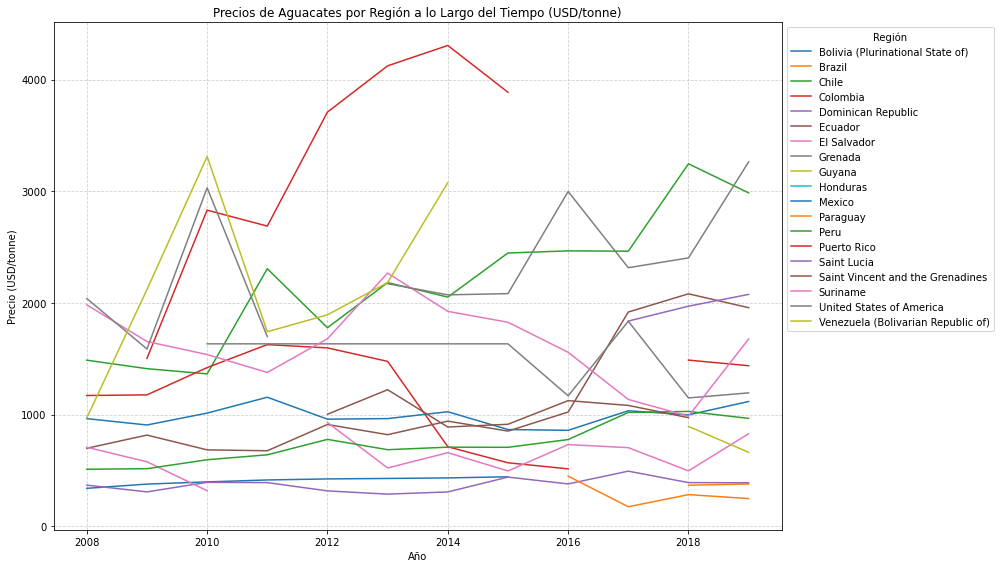

In [5]:
import matplotlib.pyplot as plt

# Crear la tabla pivote para precios por año y región
pivot_oferta = df_producer_prices.pivot_table(
    index='Year', columns='Area', values='Value'
)

# Crear la gráfica de líneas
plt.figure(figsize=(14, 8))

# Graficar cada región con una línea diferente
for country in pivot_oferta.columns:
    plt.plot(pivot_oferta.index, pivot_oferta[country], label=country)

# Personalización del gráfico
plt.title("Precios de Aguacates por Región a lo Largo del Tiempo (USD/tonne)")
plt.xlabel("Año")
plt.ylabel("Precio (USD/tonne)")
plt.legend(title="Región", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Países con Mayor Exportación:**

México destaca significativamente por su volumen exportado constante y creciente, lo que lo posiciona como un proveedor clave y confiable.
Venezuela y Guyana muestran picos de exportación en ciertos años, pero su consistencia varía, lo cual puede ser un riesgo para garantizar la oferta.
Tendencias de Crecimiento:

Países como Perú y Colombia presentan un crecimiento constante en sus exportaciones, aunque en menor volumen comparado con México. Son buenos candidatos como proveedores secundarios.
Ecuador y Dominican Republic muestran fluctuaciones, lo que indica una menor estabilidad en la oferta.
Bajos Volúmenes Exportados:

Países como Saint Lucia, Grenada y Suriname tienen volúmenes muy bajos y no parecen ser estratégicos para una compra a gran escala.
Inconsistencias en la Oferta:

Países con picos abruptos y caídas posteriores (por ejemplo, Venezuela y El Salvador) pueden tener problemas de infraestructura, producción o logística, por lo que no serían ideales para garantizar una oferta estable.
Estados Unidos:

Tiene exportaciones moderadas pero estables, lo que puede ser útil como proveedor de emergencia o secundario debido a su proximidad geográfica (dependiendo de la ubicación del hotel).

In [6]:
# Crear una tabla pivote con precios por año y región
pivot_oferta = df_producer_prices.pivot_table(
    index='Year', columns='Area', values='Value'
)

# Identificar vacíos de oferta por región
missing_data = pivot_oferta.isna().sum().reset_index()
missing_data.columns = ['Area', 'Missing Years']

# Filtrar regiones con más de un año faltante
missing_data_filtered = missing_data[missing_data['Missing Years'] > 0].sort_values('Missing Years', ascending=False)

# Mostrar datos
print("Periodos de baja oferta por región:")
print(missing_data_filtered)

Periodos de baja oferta por región:
                                  Area  Missing Years
9                             Honduras             11
1                               Brazil             10
8                               Guyana              9
11                            Paraguay              8
14                         Saint Lucia              8
13                         Puerto Rico              5
15    Saint Vincent and the Grenadines              5
18  Venezuela (Bolivarian Republic of)              5
0     Bolivia (Plurinational State of)              4
7                              Grenada              2
3                             Colombia              1
6                          El Salvador              1
17            United States of America              1


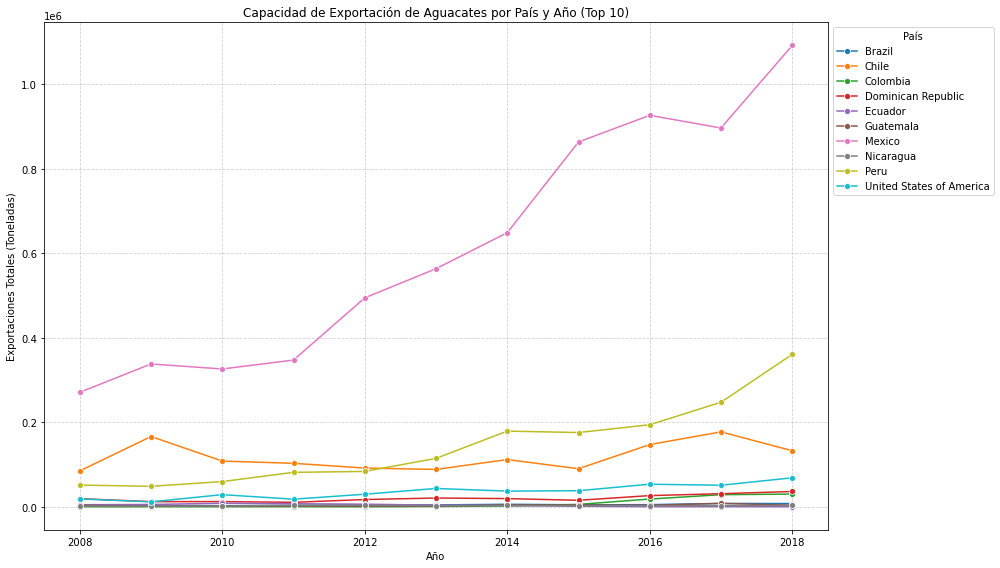

In [7]:
import matplotlib.ticker as ticker
import seaborn as sns

# Calcular el total de exportaciones por país y año en toneladas
export_capacity = df_livestock[df_livestock['Element'] == 'Export Quantity'].groupby(
    ['Area', 'Year']
).agg(
    Total_Export_Tons=('Value', 'sum')
).reset_index()

# Seleccionar el Top 10 de países con mayor capacidad total de exportación
top_10_exporters = export_capacity.groupby('Area').agg(
    Total_Export_Tons=('Total_Export_Tons', 'sum')
).reset_index().sort_values(by='Total_Export_Tons', ascending=False).head(10)

# Filtrar el DataFrame original con solo los 10 principales exportadores
export_capacity_top10 = export_capacity[export_capacity['Area'].isin(top_10_exporters['Area'])]

# Mostrar tabla de exportaciones por país y año
# Crear la gráfica de líneas para cada país
plt.figure(figsize=(14, 8))
sns.lineplot(data=export_capacity_top10, x="Year", y="Total_Export_Tons", hue="Area", marker="o")

# Personalización de la gráfica
plt.title("Capacidad de Exportación de Aguacates por País y Año (Top 10)")
plt.xlabel("Año")
plt.ylabel("Exportaciones Totales (Toneladas)")
plt.legend(title="País", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
# Filtrar y obtener nuevo dataset de los top10 exportadores.
df_livestock_top10 = df_livestock[df_livestock['Area'].isin(top_10_exporters['Area'])]

# Pivotar df_livestock para reorganizar 'Export Quantity' y 'Export Value' en columnas separadas
df_livestock_top10 = df_livestock_top10.pivot_table(
    index=['Area Code (M49)', 'Area', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()

# Renombrar las columnas para mayor claridad
df_livestock_top10.columns.name = None  # Eliminar nombre del índice de columnas
df_livestock_top10.rename(columns={
    'Export Quantity': 'Export Quantity (t)',
    'Export Value': 'Export Value (1000 USD)'
}, inplace=True)

# Mostrar el resultado final
df_livestock_top10.head()

,Area Code (M49),Area,Year,Export Quantity (t),Export Value (1000 USD)
0,76,Brazil,2008,1801.0,2366.0
1,76,Brazil,2009,2932.0,3606.0
2,76,Brazil,2010,2464.0,2929.0
3,76,Brazil,2011,3263.0,6200.0
4,76,Brazil,2012,4273.0,6841.0


### Calculo de los precios de productores

In [9]:
# Unir datasets usando Area Code (M49) y Year
merged_df_final_corrected = pd.merge(
    df_producer_prices, df_livestock_top10,
    on=['Area Code (M49)', 'Year'],
    suffixes=('_producer', '_livestock'),
    how='inner'
)

merged_df_final_corrected.rename(columns={
    'Value': 'Producer Price(USD/tonne)',
    'Area_producer': 'Area'
}, inplace=True)

In [10]:
# Preparación del dataset deseado para el análisis
df_providers = merged_df_final_corrected[['Area Code (M49)',
                                       'Area',
                                       'Year',
                                       'Producer Price(USD/tonne)',
                                       'Export Quantity (t)',
                                       'Export Value (1000 USD)']]

# Calcular el valor por tonelada (Export Value dividido por Export Quantity)
df_providers['Value Ton (USD)'] = ((df_providers['Export Value (1000 USD)'] * 1000) / df_providers['Export Quantity (t)']).round(2)

df_providers

/var/folders/5j/6t2j9zls237_klqhdt5ljdgr0000gn/T/ipykernel_88500/3914448623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_providers['Value Ton (USD)'] = ((df_providers['Export Value (1000 USD)'] * 1000) / df_providers['Export Quantity (t)']).round(2)


,Area Code (M49),Area,Year,Producer Price(USD/tonne),Export Quantity (t),Export Value (1000 USD),Value Ton (USD)
0,76,Brazil,2018,366.3,7563.70,16380.0,2165.61
1,152,Chile,2008,1486.6,84918.00,88185.0,1038.47
2,152,Chile,2009,1410.7,166192.00,283646.0,1706.74
3,152,Chile,2010,1364.0,108116.00,184731.0,1708.64
4,152,Chile,2011,2306.0,102820.00,227697.0,2214.52
...,...,...,...,...,...,...,...
71,840,United States of America,2014,2072.0,37005.11,111854.0,3022.66
72,840,United States of America,2015,2083.0,37885.85,99398.0,2623.62
73,840,United States of America,2016,2998.0,53337.01,128663.0,2412.26
74,840,United States of America,2017,2315.0,50907.35,152283.0,2991.38


In [13]:
# Calcular estadísticas por región
ranking_proveedores = df_providers.groupby('Area').agg(
    avg_price=('Value Ton (USD)', 'mean'),              # Precio promedio
    price_std=('Value Ton (USD)', 'std'),               # Desviación estándar
    min_year=('Year', 'min'),                 # Primer año registrado
    max_year=('Year', 'max'),                 # Último año registrado
    registros=('Year', 'count')               # Número de años registrados
).reset_index()

# Ordenar por precio promedio ascendente
ranking_proveedores = (ranking_proveedores.sort_values(by='registros', ascending=False)).round(2)

# Mostrar los 10 mejores
print(ranking_proveedores)

                       Area  avg_price  price_std  min_year  max_year  \
1                     Chile    2060.29     495.87      2008      2018   
3        Dominican Republic    1140.45     218.55      2008      2018   
4                   Ecuador     248.74     425.96      2008      2018   
5                    Mexico    2169.05     421.76      2008      2018   
6                      Peru    1751.38     317.76      2008      2018   
2                  Colombia    1865.04     297.92      2008      2018   
7  United States of America    2475.23     590.79      2008      2018   
0                    Brazil    2165.61        NaN      2018      2018   

   registros  
1         11  
3         11  
4         11  
5         11  
6         11  
2         10  
7         10  
0          1  


### Modelos personalizados

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Crear un DataFrame para almacenar proyecciones
projections = []

# Realizar regresión lineal para cada país
for area, group in df_providers.groupby('Area'):
    X = group['Year'].values.reshape(-1, 1)
    y = group['Producer Price(USD/tonne)'].values.reshape(-1, 1)

    # Ajustar el modelo
    model = LinearRegression()
    model.fit(X, y)

    # Generar predicciones para los próximos 3 años
    future_years = np.array([2019, 2020, 2021]).reshape(-1, 1)
    future_prices = model.predict(future_years)

    # Guardar resultados
    for year, price in zip(future_years.flatten(), future_prices.flatten()):
        projections.append({'Area': area, 'Year': year, 'Projected Price(USD/tonne)': price})

# Crear DataFrame de proyecciones
df_projections = pd.DataFrame(projections)

# Mostrar los resultados al usuario
df_projections.round(2)


,Area,Year,Projected Price(USD/tonne)
0,Brazil,2019,366.30
1,Brazil,2020,366.30
2,Brazil,2021,366.30
3,Chile,2019,3029.22
4,Chile,2020,3182.57
5,Chile,2021,3335.92
6,Colombia,2019,887.44
7,Colombia,2020,842.59
8,Colombia,2021,797.74
9,Dominican Republic,2019,418.85


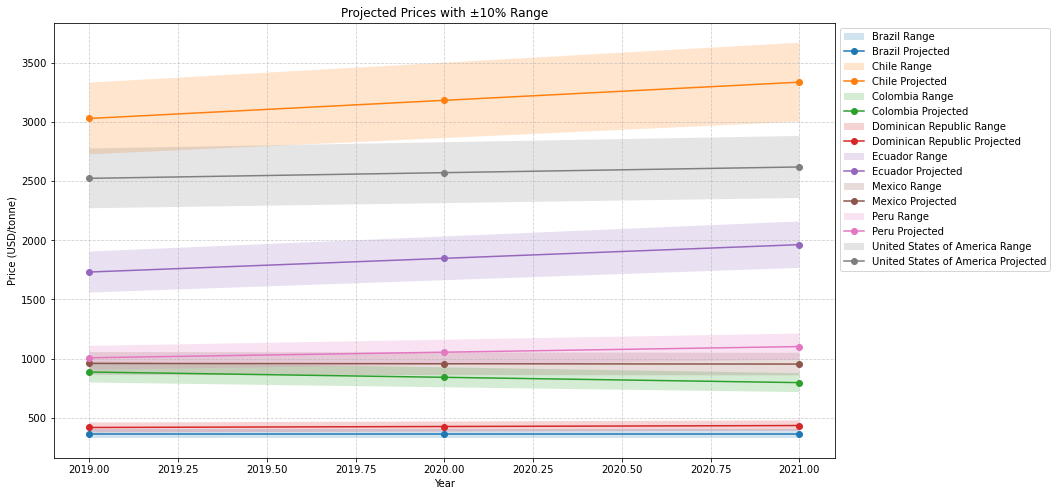

In [ ]:
# Asegurar que los datos estén en los tipos correctos
df_projections['Year'] = df_projections['Year'].astype(int)
df_projections['Projected Price(USD/tonne)'] = df_projections['Projected Price(USD/tonne)'].astype(float)

# Visualización de precios proyectados con un margen de +-10%
plt.figure(figsize=(14, 8))

for area in df_projections['Area'].unique():
    area_data = df_projections[df_projections['Area'] == area]
    years = area_data['Year']
    prices = area_data['Projected Price(USD/tonne)']
    lower_bound = prices * 0.9
    upper_bound = prices * 1.1

    plt.fill_between(years, lower_bound, upper_bound, alpha=0.2, label=f"{area} Range")
    plt.plot(years, prices, marker='o', label=f"{area} Projected")

plt.title("Projected Prices with ±10% Range")
plt.xlabel("Year")
plt.ylabel("Price (USD/tonne)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Podemos observar el rango de precios obtenido en la regresión lineral con un +-10% para cada uno de los países exportadores, podemos notar un ligero aumento en Chile, Estados Unidos y Ecuador, en cambio en otros retrocede, y en otros se mantiene, como lo son Brasil y República Dominicana, para el caso de Brasil esto se debe a que tiene un histórico más limitado, en el caso de República Dominciana, se caracteriza por mantener buenos precios.

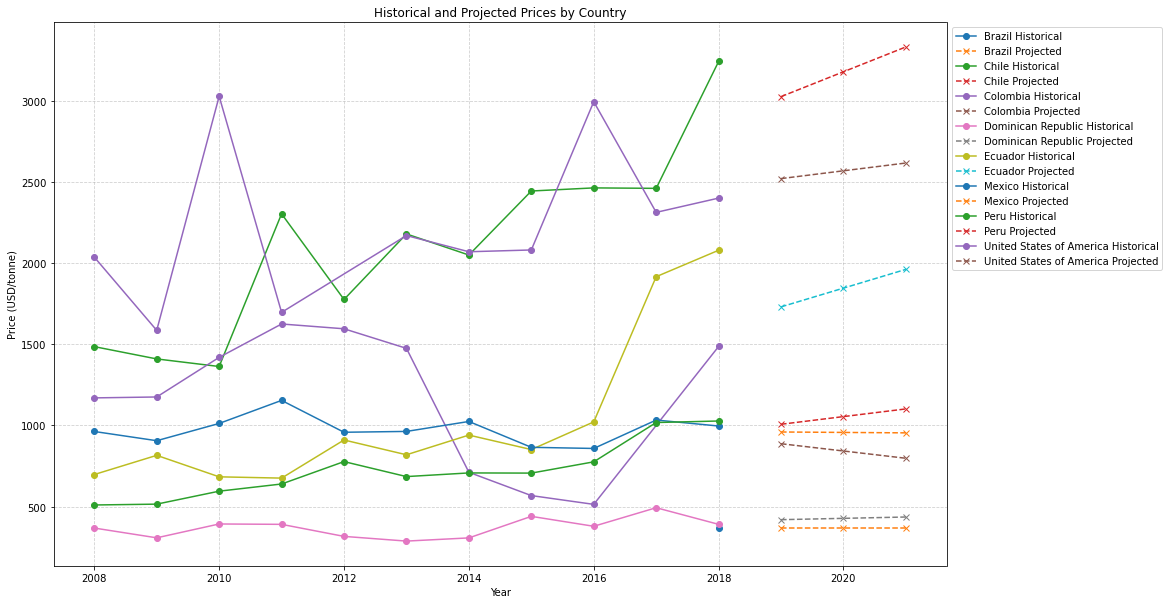

In [ ]:
# Combinar datos originales y proyecciones
df_combined = pd.concat([df_providers[['Area', 'Year', 'Producer Price(USD/tonne)']].rename(
    columns={'Producer Price(USD/tonne)': 'Price(USD/tonne)'}),
    df_projections.rename(columns={'Projected Price(USD/tonne)': 'Price(USD/tonne)'})],
    ignore_index=True)

# Visualizar datos históricos y proyecciones
plt.figure(figsize=(16, 10))

for area in df_combined['Area'].unique():
    area_data = df_combined[df_combined['Area'] == area]
    years = area_data['Year']
    prices = area_data['Price(USD/tonne)']

    # Separar datos originales y proyectados
    historical_data = area_data[area_data['Year'] <= 2018]
    projected_data = area_data[area_data['Year'] > 2018]

    # Graficar
    plt.plot(historical_data['Year'], historical_data['Price(USD/tonne)'],
             marker='o', label=f"{area} Historical", linestyle='-')
    plt.plot(projected_data['Year'], projected_data['Price(USD/tonne)'],
             marker='x', label=f"{area} Projected", linestyle='--')

plt.title("Historical and Projected Prices by Country")
plt.xlabel("Year")
plt.ylabel("Price (USD/tonne)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Tendencias Históricas:**
- La mayoría de los países muestran fluctuaciones en los precios históricos entre 2008 y 2018.
- Colombia y Chile presentan picos y caídas notorias en ciertos años, lo que podría sugerir eventos económicos específicos o variabilidad alta en el mercado.

**Proyecciones:**
- Las proyecciones (líneas punteadas) para todos los países muestran trayectorias lineales debido a la naturaleza de la regresión lineal.
- Para países como Chile y Estados Unidos, la proyección parece seguir la tendencia ascendente de los últimos años históricos, lo cual parece razonable.
- En México y Ecuador, las proyecciones son prácticamente planas, lo que indica poca variabilidad en los datos históricos recientes.

**Sobreajuste o Subajuste:**
- Algunos países con tendencias más complejas (como Colombia) muestran proyecciones lineales que no capturan las fluctuaciones históricas, lo que podría sugerir subajuste.
- Para otros países con datos estables (como Brazil y México), la proyección lineal se ajusta razonablemente bien.
**Anomalías:**

- El caso de Colombia merece atención debido a los picos y caídas bruscas. Aplicar un modelo más complejo, como regresión polinómica o modelos de series temporales, podría capturar mejor la dinámica de estos datos.

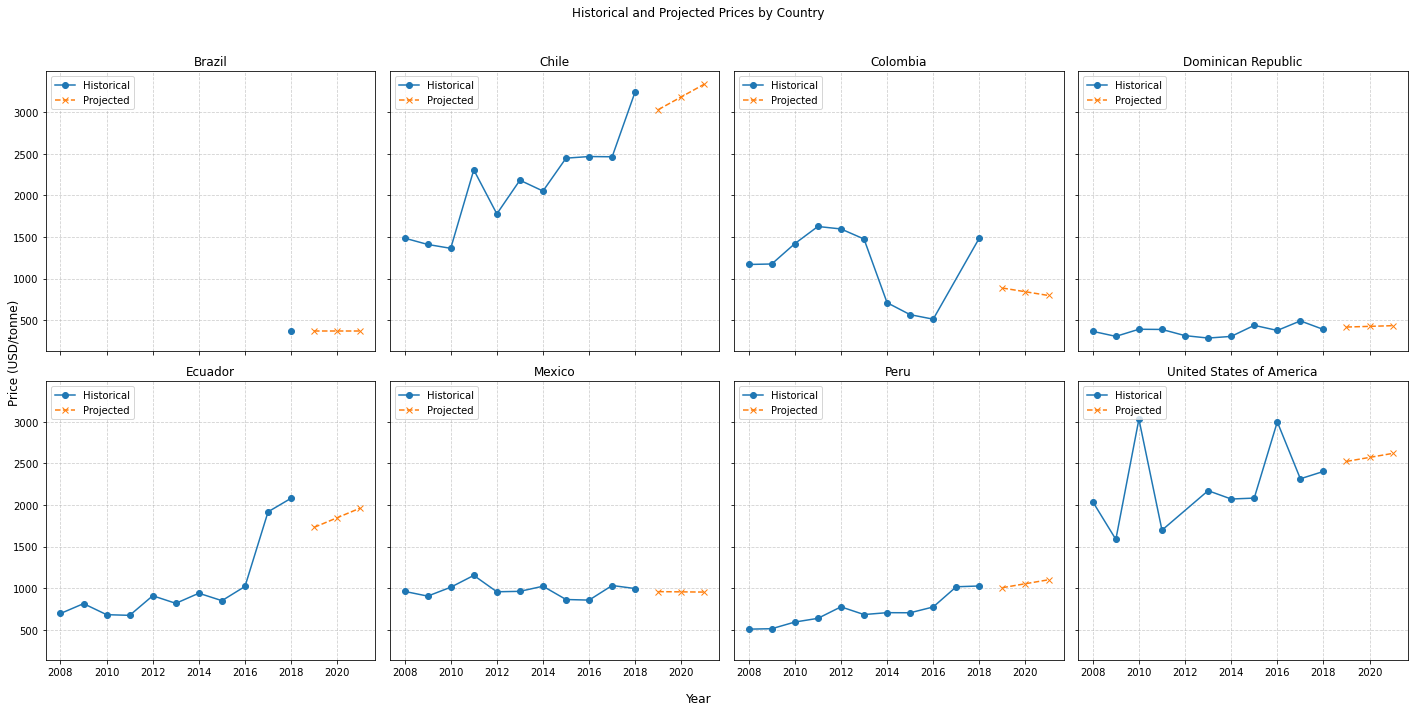

In [ ]:
# Crear una visualización con subgráficos 2x4 para cada país
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Filtrar países únicos
unique_areas = df_combined['Area'].unique()

# Graficar por país
for ax, area in zip(axes, unique_areas):
    area_data = df_combined[df_combined['Area'] == area]

    # Separar datos históricos y proyectados
    historical_data = area_data[area_data['Year'] <= 2018]
    projected_data = area_data[area_data['Year'] > 2018]

    # Graficar datos
    ax.plot(historical_data['Year'], historical_data['Price(USD/tonne)'],
            marker='o', linestyle='-', label='Historical')
    ax.plot(projected_data['Year'], projected_data['Price(USD/tonne)'],
            marker='x', linestyle='--', label='Projected')

    ax.set_title(f"{area}")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc="upper left")

# Ajustes finales
fig.suptitle("Historical and Projected Prices by Country")
fig.supxlabel("Year")
fig.supylabel("Price (USD/tonne)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# Diccionario para almacenar las métricas R^2
r2_metrics = []

# Calcular R² para cada país
for area, group in df_providers.groupby('Area'):
    X = group['Year'].values.reshape(-1, 1)
    y = group['Producer Price(USD/tonne)'].values.reshape(-1, 1)

    # Ajustar modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calcular R²
    r2 = r2_score(y, y_pred)
    r2_metrics.append({'Area': area, 'R2': r2})

# Convertir a DataFrame
df_r2_metrics = pd.DataFrame(r2_metrics)

# Mostrar resultados
df_r2_metrics

Con el cálculo del error cuadrático medio observamos que el modelo de regresión es adecuado para Chile, Perú y Ecuador en cambio para lugares más fluctuantes como Colombia, Republica Dominicana, México y Estados Unidos se provará un modelo de regresión polinómica de grado dos.

In [45]:
from sklearn.preprocessing import PolynomialFeatures

# Lista de países con bajo R2
low_r2_countries = ['Colombia', 'Dominican Republic', 'Mexico', 'United States of America']

# Diccionario para almacenar métricas
poly_r2_metrics = []

# Aplicar regresión polinómica de grado 2
for area, group in df_providers.groupby('Area'):
    if area in low_r2_countries:
        X = group['Year'].values.reshape(-1, 1)
        y = group['Producer Price(USD/tonne)'].values.reshape(-1, 1)

        # Crear características polinómicas de grado 2
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X)

        # Ajustar el modelo
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)

        # Calcular R2
        r2 = r2_score(y, y_pred)
        poly_r2_metrics.append({'Area': area, 'Polynomial R2': r2})

# Crear DataFrame de resultados
df_poly_r2 = pd.DataFrame(poly_r2_metrics)

# Mostrar los resultados
df_poly_r2

,Area,Polynomial R2
0,Colombia,0.115992
1,Dominican Republic,0.302195
2,Mexico,0.014406
3,United States of America,0.123772


Para Colombia, un modelo polinómico de grado 3 es adecuado y mejora considerablemente el ajuste.
México y República Dominicana aún muestran un ajuste limitado. Modelos más complejos, como series temporales o modelos no lineales como Random Forest, podrían ser más efectivos.

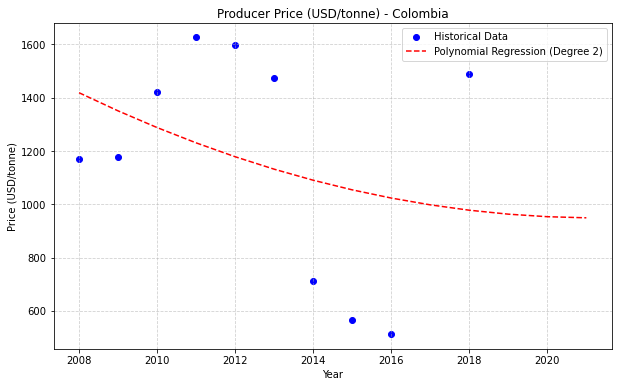

In [46]:
# Filtrar los datos para Colombia
colombia_data = df_providers[df_providers['Area'] == 'Colombia']

# Variables
X = colombia_data['Year'].values.reshape(-1, 1)
y = colombia_data['Producer Price(USD/tonne)'].values.reshape(-1, 1)

# Crear características polinómicas de grado 3
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Ajustar el modelo
model = LinearRegression()
model.fit(X_poly, y)

# Generar predicciones en el rango completo de años (históricos y futuros)
years_extended = np.arange(2008, 2022).reshape(-1, 1)
years_poly = poly.transform(years_extended)
predictions = model.predict(years_poly)

# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Historical Data')
plt.plot(years_extended, predictions, color='red', linestyle='--', label='Polynomial Regression (Degree 2)')
plt.title('Producer Price (USD/tonne) - Colombia')
plt.xlabel('Year')
plt.ylabel('Price (USD/tonne)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Después de probar la regresión polinómica en diversos rangos, para el rango 2 aunque el R2 es menor, se puede observar una gráfica más adecuada y no sobreajustada.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Diccionario para almacenar métricas R² del modelo Random Forest
rf_r2_metrics = []

# Aplicar Random Forest para los países restantes
for area, group in df_providers.groupby('Area'):
    if area in low_r2_countries:  # Países con bajo R2 previo
        X = group['Year'].values.reshape(-1, 1)
        y = group['Producer Price(USD/tonne)'].values.reshape(-1, 1).ravel()

        # Ajustar modelo Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        y_pred = model.predict(X)

        # Calcular R²
        r2 = r2_score(y, y_pred)
        rf_r2_metrics.append({'Area': area, 'Random Forest R2': r2})

# Crear DataFrame de resultados
df_rf_r2 = pd.DataFrame(rf_r2_metrics)

# Mostrar los resultados
df_rf_r2

,Area,Random Forest R2
0,Colombia,0.909238
1,Dominican Republic,0.837261
2,Mexico,0.809498
3,United States of America,0.749613


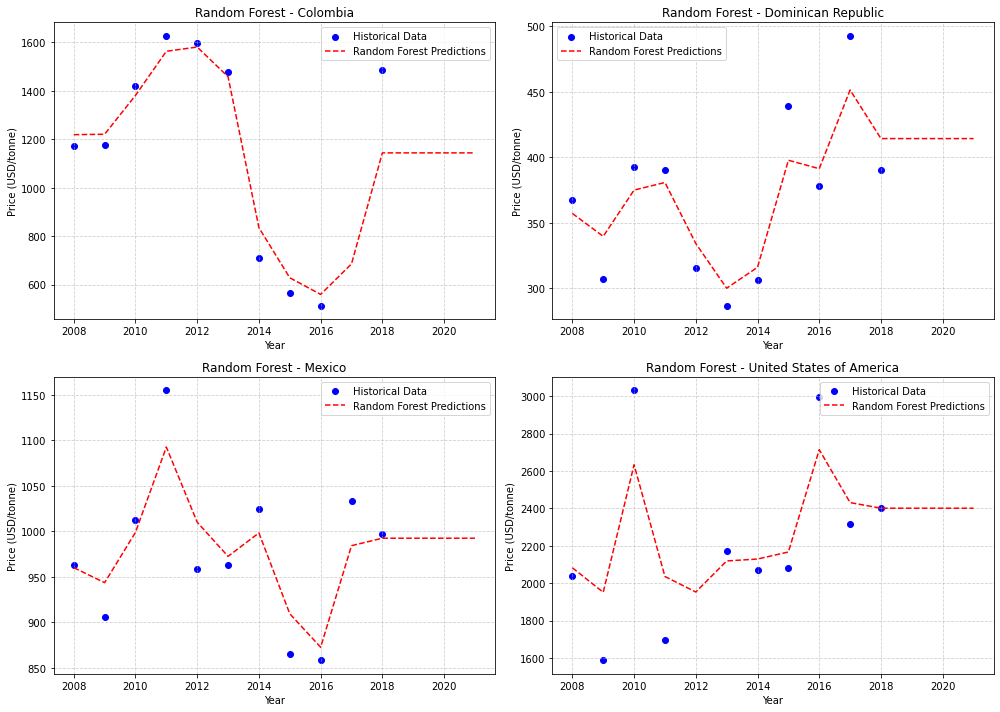

In [ ]:
# Visualización para los países con Random Forest
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
random_forest_countries = ['Colombia', 'Dominican Republic', 'Mexico', 'United States of America']

# Visualizar cada país
for i, area in enumerate(random_forest_countries):
    group = df_providers[df_providers['Area'] == area]
    X = group['Year'].values.reshape(-1, 1)
    y = group['Producer Price(USD/tonne)'].values.reshape(-1, 1).ravel()

    # Ajustar modelo Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predicciones en el rango extendido (histórico + futuro)
    years_extended = np.arange(min(X), 2022).reshape(-1, 1)
    predictions = model.predict(years_extended)

    # Visualización
    axes[i].scatter(X, y, color='blue', label='Historical Data')
    axes[i].plot(years_extended, predictions, color='red', linestyle='--', label='Random Forest Predictions')
    axes[i].set_title(f"Random Forest - {area}")
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Price (USD/tonne)')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Ajustes de layout
fig.tight_layout()
plt.show()